# 深度学习模型排名预测

### （注：由于深度学习每次训练过程存在随机性，notebook中的结果与报告中存在细微差异）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

academic_fields = [
    "Agricultural Sciences", "Biology & Biochemistry", "Chemistry", "Clinical Medicine", "Computer Science", "Economics & Business", "Engineering", "Environment Ecology", "Geosciences", "Immunology", "Materials Science", "Mathematics", "Microbiology", "Molecular Biology & Genetics", "Multidisciplinary", "Neuroscience & Behavior", "Pharmacology & Toxicology", "Physics", "Plant & Animal Science", "Psychiatry Psychology", "Social Sciences, General", "Space Science"
]

In [2]:
csv_dir = Path('csv')
csv_files = sorted([f for f in csv_dir.glob('*.csv') if f.name != '0-ALL.csv'])

print(f"共找到 {len(csv_files)} 个学科文件")

# 按照名称开头的数字排序
import re
def extract_prefix_num(f):
    m = re.match(r"(\d+)-", f.name)
    return int(m.group(1)) if m else float('inf')

csv_files = sorted(csv_files, key=extract_prefix_num)


共找到 22 个学科文件


## 提取 排名, Web of Science Documents, Cites, Top Papers

In [3]:
all_data = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, skiprows=1, encoding='latin1')
    df[df.columns[0]] = df[df.columns[0]].apply(lambda x: int(x) if str(x).isdigit() else x)
    needed_cols = [df.columns[0], 'Web of Science Documents', 'Cites', 'Top Papers']
    cur_data = df[needed_cols].copy()
    # 将数据转为numpy数组，保持顺序: 排名, Web of Science Documents, Cites, Top Papers
    arr = cur_data.to_numpy()
    all_data.append(arr)

# all_data形状: (22个学科, 行数, 4个特征)
all_data[0]

array([[1, 15661.0, 332254.0, 251.0],
       [2, 12222.0, 223855.0, 198.0],
       [3, 12564.0, 220644.0, 105.0],
       ...,
       [1380, 108.0, 3561.0, 4.0],
       [1381, 144.0, 3558.0, 2.0],
       ['Copyright © 2025 Clarivate', nan, nan, nan]],
      shape=(1382, 4), dtype=object)

In [4]:
# 保存每个学科的真实排名范围信息
subject_ranking_ranges = {}

# 从原始数据中提取每个学科的真实排名范围
for i, arr in enumerate(all_data):
    subject_name = academic_fields[i]
    
    # 提取原始排名数据
    original_ranks = []
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            original_ranks.append(float(row[0]))
    
    if len(original_ranks) > 0:
        min_rank = min(original_ranks)
        max_rank = max(original_ranks)
        subject_ranking_ranges[subject_name] = {
            'min_rank': min_rank,
            'max_rank': max_rank
        }
    else:
        # 如果没有数据，使用默认值
        subject_ranking_ranges[subject_name] = {
            'min_rank': 1,
            'max_rank': 1000
        }

print(f"已保存 {len(subject_ranking_ranges)} 个学科的排名范围信息")
print("前5个学科的排名范围:")
for i, (subject, ranges) in enumerate(list(subject_ranking_ranges.items())[:5]):
    print(f"  {subject}: {ranges['min_rank']:.0f} - {ranges['max_rank']:.0f}")

# 显示所有学科的排名范围
print("\n所有学科的排名范围:")
for subject, ranges in subject_ranking_ranges.items():
    print(f"  {subject}: {ranges['min_rank']:.0f} - {ranges['max_rank']:.0f}")


已保存 22 个学科的排名范围信息
前5个学科的排名范围:
  Agricultural Sciences: 1 - 1381
  Biology & Biochemistry: 1 - 1649
  Chemistry: 1 - 2141
  Clinical Medicine: 1 - 6754
  Computer Science: 1 - 863

所有学科的排名范围:
  Agricultural Sciences: 1 - 1381
  Biology & Biochemistry: 1 - 1649
  Chemistry: 1 - 2141
  Clinical Medicine: 1 - 6754
  Computer Science: 1 - 863
  Economics & Business: 1 - 543
  Engineering: 1 - 2786
  Environment Ecology: 1 - 2066
  Geosciences: 1 - 1175
  Immunology: 1 - 1175
  Materials Science: 1 - 1580
  Mathematics: 1 - 395
  Microbiology: 1 - 803
  Molecular Biology & Genetics: 1 - 1169
  Multidisciplinary: 1 - 216
  Neuroscience & Behavior: 1 - 1298
  Pharmacology & Toxicology: 1 - 1389
  Physics: 1 - 995
  Plant & Animal Science: 1 - 1950
  Psychiatry Psychology: 1 - 1147
  Social Sciences, General: 1 - 2406
  Space Science: 1 - 236


## 归一化

In [5]:
# 对all_data进行归一化：将排名列“反向归一化”到[0,1]（越靠前越接近1，越靠后越接近0），其他三列正向归一化到[0,1]

from sklearn.preprocessing import MinMaxScaler

normed_all_data = []

for arr in all_data:
    arr_numeric_rows = []
    # 只对有效数值行归一化，保留非数字行
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            arr_numeric_rows.append(row)
    arr_numeric_rows = np.array(arr_numeric_rows, dtype=object)
    if len(arr_numeric_rows) == 0:
        normed_all_data.append(arr)
        continue
    # 反向归一化排名列
    rank_col = arr_numeric_rows[:, 0].astype(float)
    min_rank = np.min(rank_col)
    max_rank = np.max(rank_col)
    # 防止除0，只有一个rank时
    if max_rank == min_rank:
        normed_rank = np.ones_like(rank_col)
    else:
        normed_rank = (max_rank - rank_col) / (max_rank - min_rank)
    # 后三列归一化
    scaler = MinMaxScaler()
    other_cols = arr_numeric_rows[:, 1:4].astype(float)
    normed_other_cols = scaler.fit_transform(other_cols)
    # 拼接归一化之后的数组
    arr_norm = np.concatenate([
        normed_rank.reshape(-1, 1), 
        normed_other_cols
    ], axis=1)
    # 如果原arr有非数值行，将其加回去
    if arr.shape[0] > arr_norm.shape[0]:
        for row in arr:
            if not (isinstance(row[0], (int, float)) and not pd.isnull(row[0])):
                # 插回末尾
                arr_norm = np.vstack([arr_norm, row])
    normed_all_data.append(arr_norm)

# 用归一化后的数据替换 all_data
all_data = normed_all_data
all_data[0]


array([[1.0, 0.9999999999999999, 1.0, 1.0],
       [0.9992753623188406, 0.7799462503199386, 0.6702150315184853,
        0.7888446215139442],
       [0.9985507246376811, 0.8018300486306629, 0.6604461265120355,
        0.41832669322709165],
       ...,
       [0.0007246376811594203, 0.0047990785769132325,
        9.12697446880939e-06, 0.01593625498007968],
       [0.0, 0.007102636293831583, 0.0, 0.00796812749003984],
       ['Copyright © 2025 Clarivate', nan, nan, nan]],
      shape=(1382, 4), dtype=object)

## 数据预处理并划分数据集


In [6]:
# 数据预处理：为每个学科单独划分训练/验证/测试集
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# 为每个学科单独处理数据
subject_data = {}  # 存储每个学科的数据

for i, arr in enumerate(all_data):
    subject_name = academic_fields[i]
    
    # 提取该学科的特征和标签
    X_data = []  # 特征：[Web of Science Documents, Cites, Top Papers]
    y_data = []  # 标签：排名（归一化后的）
    
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            # 特征：后三列（Web of Science Documents, Cites, Top Papers）
            features = [float(row[1]), float(row[2]), float(row[3])]
            # 标签：排名（归一化后）
            label = float(row[0])
            X_data.append(features)
            y_data.append(label)
    
    if len(X_data) > 0:  # 确保有数据
        X = np.array(X_data)
        y = np.array(y_data)
        
        # 随机打乱数据
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # 按60%, 20%, 20%划分训练/验证/测试集
        X_train, X_temp, y_train, y_temp = train_test_split(
            X_shuffled, y_shuffled, test_size=0.4, random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42
        )
        
        subject_data[subject_name] = {
            'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val,
            'X_test': X_test, 'y_test': y_test
        }
        
        # print(f"{subject_name}: 训练集={X_train.shape[0]}, 验证集={X_val.shape[0]}, 测试集={X_test.shape[0]}")

print(f"\n总共处理了 {len(subject_data)} 个学科的数据")



总共处理了 22 个学科的数据


## 深度学习模型

In [7]:
# 构建深度学习模型
class RankingPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, dropout_rate=0.3):
        super(RankingPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size//2, hidden_size//4),
            nn.ReLU(),
            nn.Linear(hidden_size//4, 1),
            nn.Sigmoid()  # 输出范围[0,1]
        )
    
    def forward(self, x):
        return self.network(x)


## 训练

In [8]:
# 训练函数
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        indices = torch.randperm(X_train.size(0))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, X_train.size(0), batch_size):
            batch_X = X_shuffled[i:i+batch_size]
            batch_y = y_shuffled[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        
        train_losses.append(train_loss / (X_train.size(0) // batch_size + 1))
        val_losses.append(val_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}')
    
    return train_losses, val_losses

In [9]:
# 为每个学科单独训练模型
subject_models = {}
subject_results = {}

print("开始为每个学科训练模型...")

for subject_name, data in subject_data.items():
    print(f"\n正在训练: {subject_name}")
    
    # 转换为PyTorch张量
    X_train_tensor = torch.FloatTensor(data['X_train'])
    X_val_tensor = torch.FloatTensor(data['X_val'])
    X_test_tensor = torch.FloatTensor(data['X_test'])
    y_train_tensor = torch.FloatTensor(data['y_train']).reshape(-1, 1)
    y_val_tensor = torch.FloatTensor(data['y_val']).reshape(-1, 1)
    y_test_tensor = torch.FloatTensor(data['y_test']).reshape(-1, 1)
    
    # 创建模型
    model = RankingPredictor()
    
    # 训练模型
    train_losses, val_losses = train_model(
        model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
        epochs=100, batch_size=min(32, len(data['X_train']))
    )
    
    # 保存模型和结果
    subject_models[subject_name] = model
    subject_results[subject_name] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'X_test': data['X_test'],
        'y_test': data['y_test'],
        'X_test_tensor': X_test_tensor,
        'y_test_tensor': y_test_tensor
    }
    
    print(f"训练完成: {subject_name}")

print(f"\n所有学科训练完成！共训练了 {len(subject_models)} 个模型")


开始为每个学科训练模型...

正在训练: Agricultural Sciences
Epoch [20/100], Train Loss: 0.011946, Val Loss: 0.007559
Epoch [40/100], Train Loss: 0.007758, Val Loss: 0.004741
Epoch [60/100], Train Loss: 0.005286, Val Loss: 0.003000
Epoch [80/100], Train Loss: 0.003772, Val Loss: 0.001647
Epoch [100/100], Train Loss: 0.002791, Val Loss: 0.001156
训练完成: Agricultural Sciences

正在训练: Biology & Biochemistry
Epoch [20/100], Train Loss: 0.011877, Val Loss: 0.008033
Epoch [40/100], Train Loss: 0.007886, Val Loss: 0.004905
Epoch [60/100], Train Loss: 0.004556, Val Loss: 0.002428
Epoch [80/100], Train Loss: 0.003392, Val Loss: 0.001494
Epoch [100/100], Train Loss: 0.002579, Val Loss: 0.000912
训练完成: Biology & Biochemistry

正在训练: Chemistry
Epoch [20/100], Train Loss: 0.011005, Val Loss: 0.005873
Epoch [40/100], Train Loss: 0.007367, Val Loss: 0.004112
Epoch [60/100], Train Loss: 0.005416, Val Loss: 0.003117
Epoch [80/100], Train Loss: 0.004073, Val Loss: 0.002370
Epoch [100/100], Train Loss: 0.003437, Val Loss: 0.0

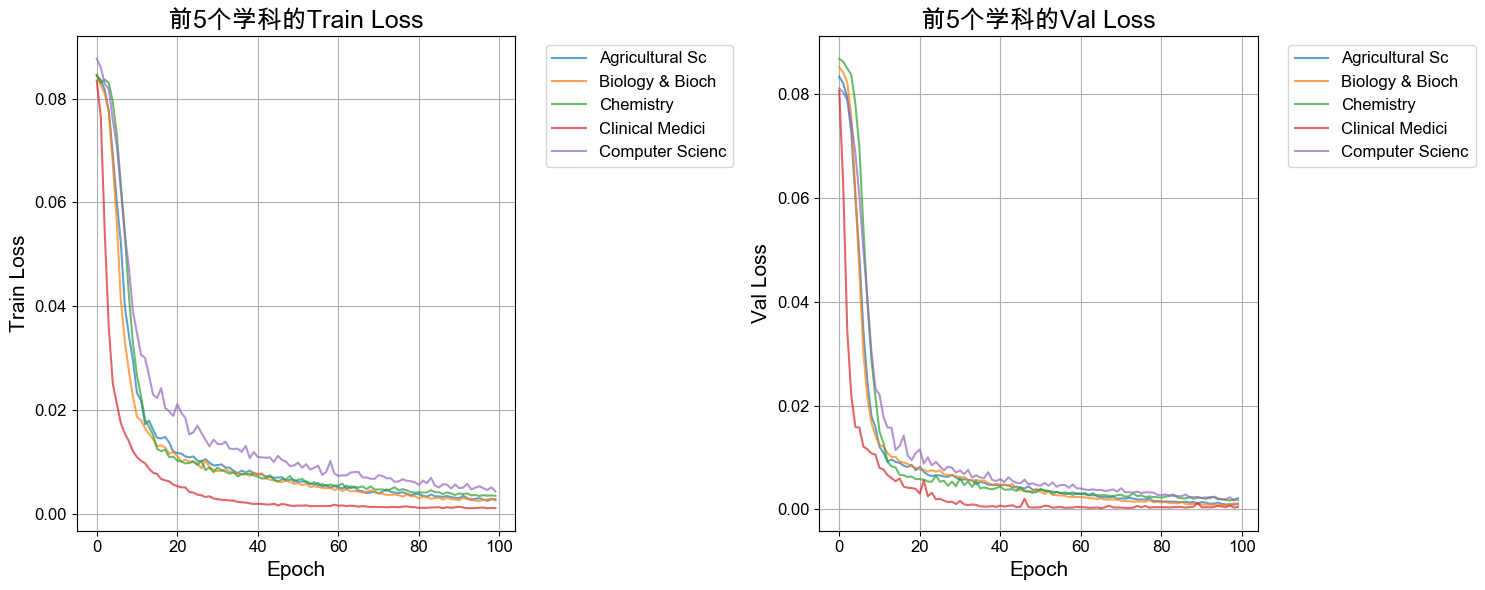

In [10]:
# 训练损失可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 只画前5个学科
subject_items = list(subject_results.items())[:5]

# 1. Train Loss
for subject_name, result in subject_items:
    train_losses = result['train_losses']
    axes[0].plot(train_losses, alpha=0.7, label=subject_name[:15])

axes[0].set_title('前5个学科的Train Loss', fontsize=18)
axes[0].set_xlabel('Epoch', fontsize=15)
axes[0].set_ylabel('Train Loss', fontsize=15)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].grid(True)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 2. Val Loss
for subject_name, result in subject_items:
    val_losses = result['val_losses']
    axes[1].plot(val_losses, alpha=0.7, label=subject_name[:15])

axes[1].set_title('前5个学科的Val Loss', fontsize=18)
axes[1].set_xlabel('Epoch', fontsize=15)
axes[1].set_ylabel('Val Loss', fontsize=15)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].grid(True)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()


## 计算 MSE、MAE、MAPE(%)、R²四项指标

In [11]:
# 反归一化函数：使用真实的排名范围
def denormalize_ranking_fixed(normalized_rank, subject_name):
    """将归一化的排名转换回原始排名，使用真实的排名范围"""
    if subject_name in subject_ranking_ranges:
        ranges = subject_ranking_ranges[subject_name]
        min_rank = ranges['min_rank']
        max_rank = ranges['max_rank']
    else:
        # 如果找不到该学科的范围信息，使用默认值
        min_rank, max_rank = 1, 1000
    original_rank = max_rank - normalized_rank * (max_rank - min_rank)
    return original_rank

def evaluate_model_fixed(model, X_test, y_test, subject_name):
    """使用真实的原始数据进行MAPE计算"""
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions_np = predictions.numpy().flatten()
        y_test_np = y_test.numpy().flatten()
    # 计算各种评价指标
    mse = mean_squared_error(y_test_np, predictions_np)
    mae = np.mean(np.abs(y_test_np - predictions_np))
    # MAPE计算：使用真实的原始数据进行反归一化
    original_y_test = denormalize_ranking_fixed(y_test_np, subject_name)
    original_predictions = denormalize_ranking_fixed(predictions_np, subject_name)
    # 避免除零错误
    mask = original_y_test != 0
    if np.any(mask):
        mape = np.mean(np.abs((original_y_test[mask] - original_predictions[mask]) / original_y_test[mask])) * 100
    else:
        mape = 0
    r2 = 1 - (np.sum((y_test_np - predictions_np) ** 2) / np.sum((y_test_np - np.mean(y_test_np)) ** 2))
    return predictions_np, mse, mae, mape, r2

metrics_list = []
all_subject_metrics = {}

for subject_name, model in subject_models.items():
    result = subject_results[subject_name]
    predictions, mse, mae, mape, r2 = evaluate_model_fixed(
        model, result['X_test_tensor'], result['y_test_tensor'], subject_name
    )
    # 保存结果到dict
    all_subject_metrics[subject_name] = {
        'predictions': predictions,
        'mse': mse, 'mae': mae, 'mape': mape, 'r2': r2
    }
    metrics_list.append({
        '学科名称': subject_name,
        'MSE': mse,
        'MAE': mae,
        'MAPE(%)': mape,
        'R²': r2
    })

# 创建DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df[['学科名称', 'MSE', 'MAE', 'MAPE(%)', 'R²']]

# 计算整体统计
all_mse_fixed = [metrics['mse'] for metrics in all_subject_metrics.values()]
all_mae_fixed = [metrics['mae'] for metrics in all_subject_metrics.values()]
all_mape_fixed = [metrics['mape'] for metrics in all_subject_metrics.values()]
all_r2_fixed = [metrics['r2'] for metrics in all_subject_metrics.values()]
# 平均数
average_row = {
    '学科名称': '平均值',
    'MSE': np.mean(all_mse_fixed),
    'MAE': np.mean(all_mae_fixed),
    'MAPE(%)': np.mean(all_mape_fixed),
    'R²': np.mean(all_r2_fixed)
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_row])], ignore_index=True)

display(metrics_df.style.format({'MSE': '{:.6f}', 'MAE': '{:.6f}', 'MAPE(%)': '{:.2f}', 'R²': '{:.6f}'}))



,学科名称,MSE,MAE,MAPE(%),R²
0,Agricultural Sciences,0.001325,0.026151,7.48,0.983341
1,Biology & Biochemistry,0.000974,0.021924,8.50,0.988343
2,Chemistry,0.001882,0.034042,10.63,0.975827
3,Clinical Medicine,0.000497,0.016845,9.90,0.993996
4,Computer Science,0.002067,0.032703,9.27,0.974108
5,Economics & Business,0.004167,0.047272,10.52,0.951498
6,Engineering,0.000953,0.021497,6.55,0.988944
7,Environment Ecology,0.001745,0.029336,9.28,0.978670
8,Geosciences,0.002595,0.036310,11.54,0.969541
9,Immunology,0.001320,0.027297,9.97,0.983648


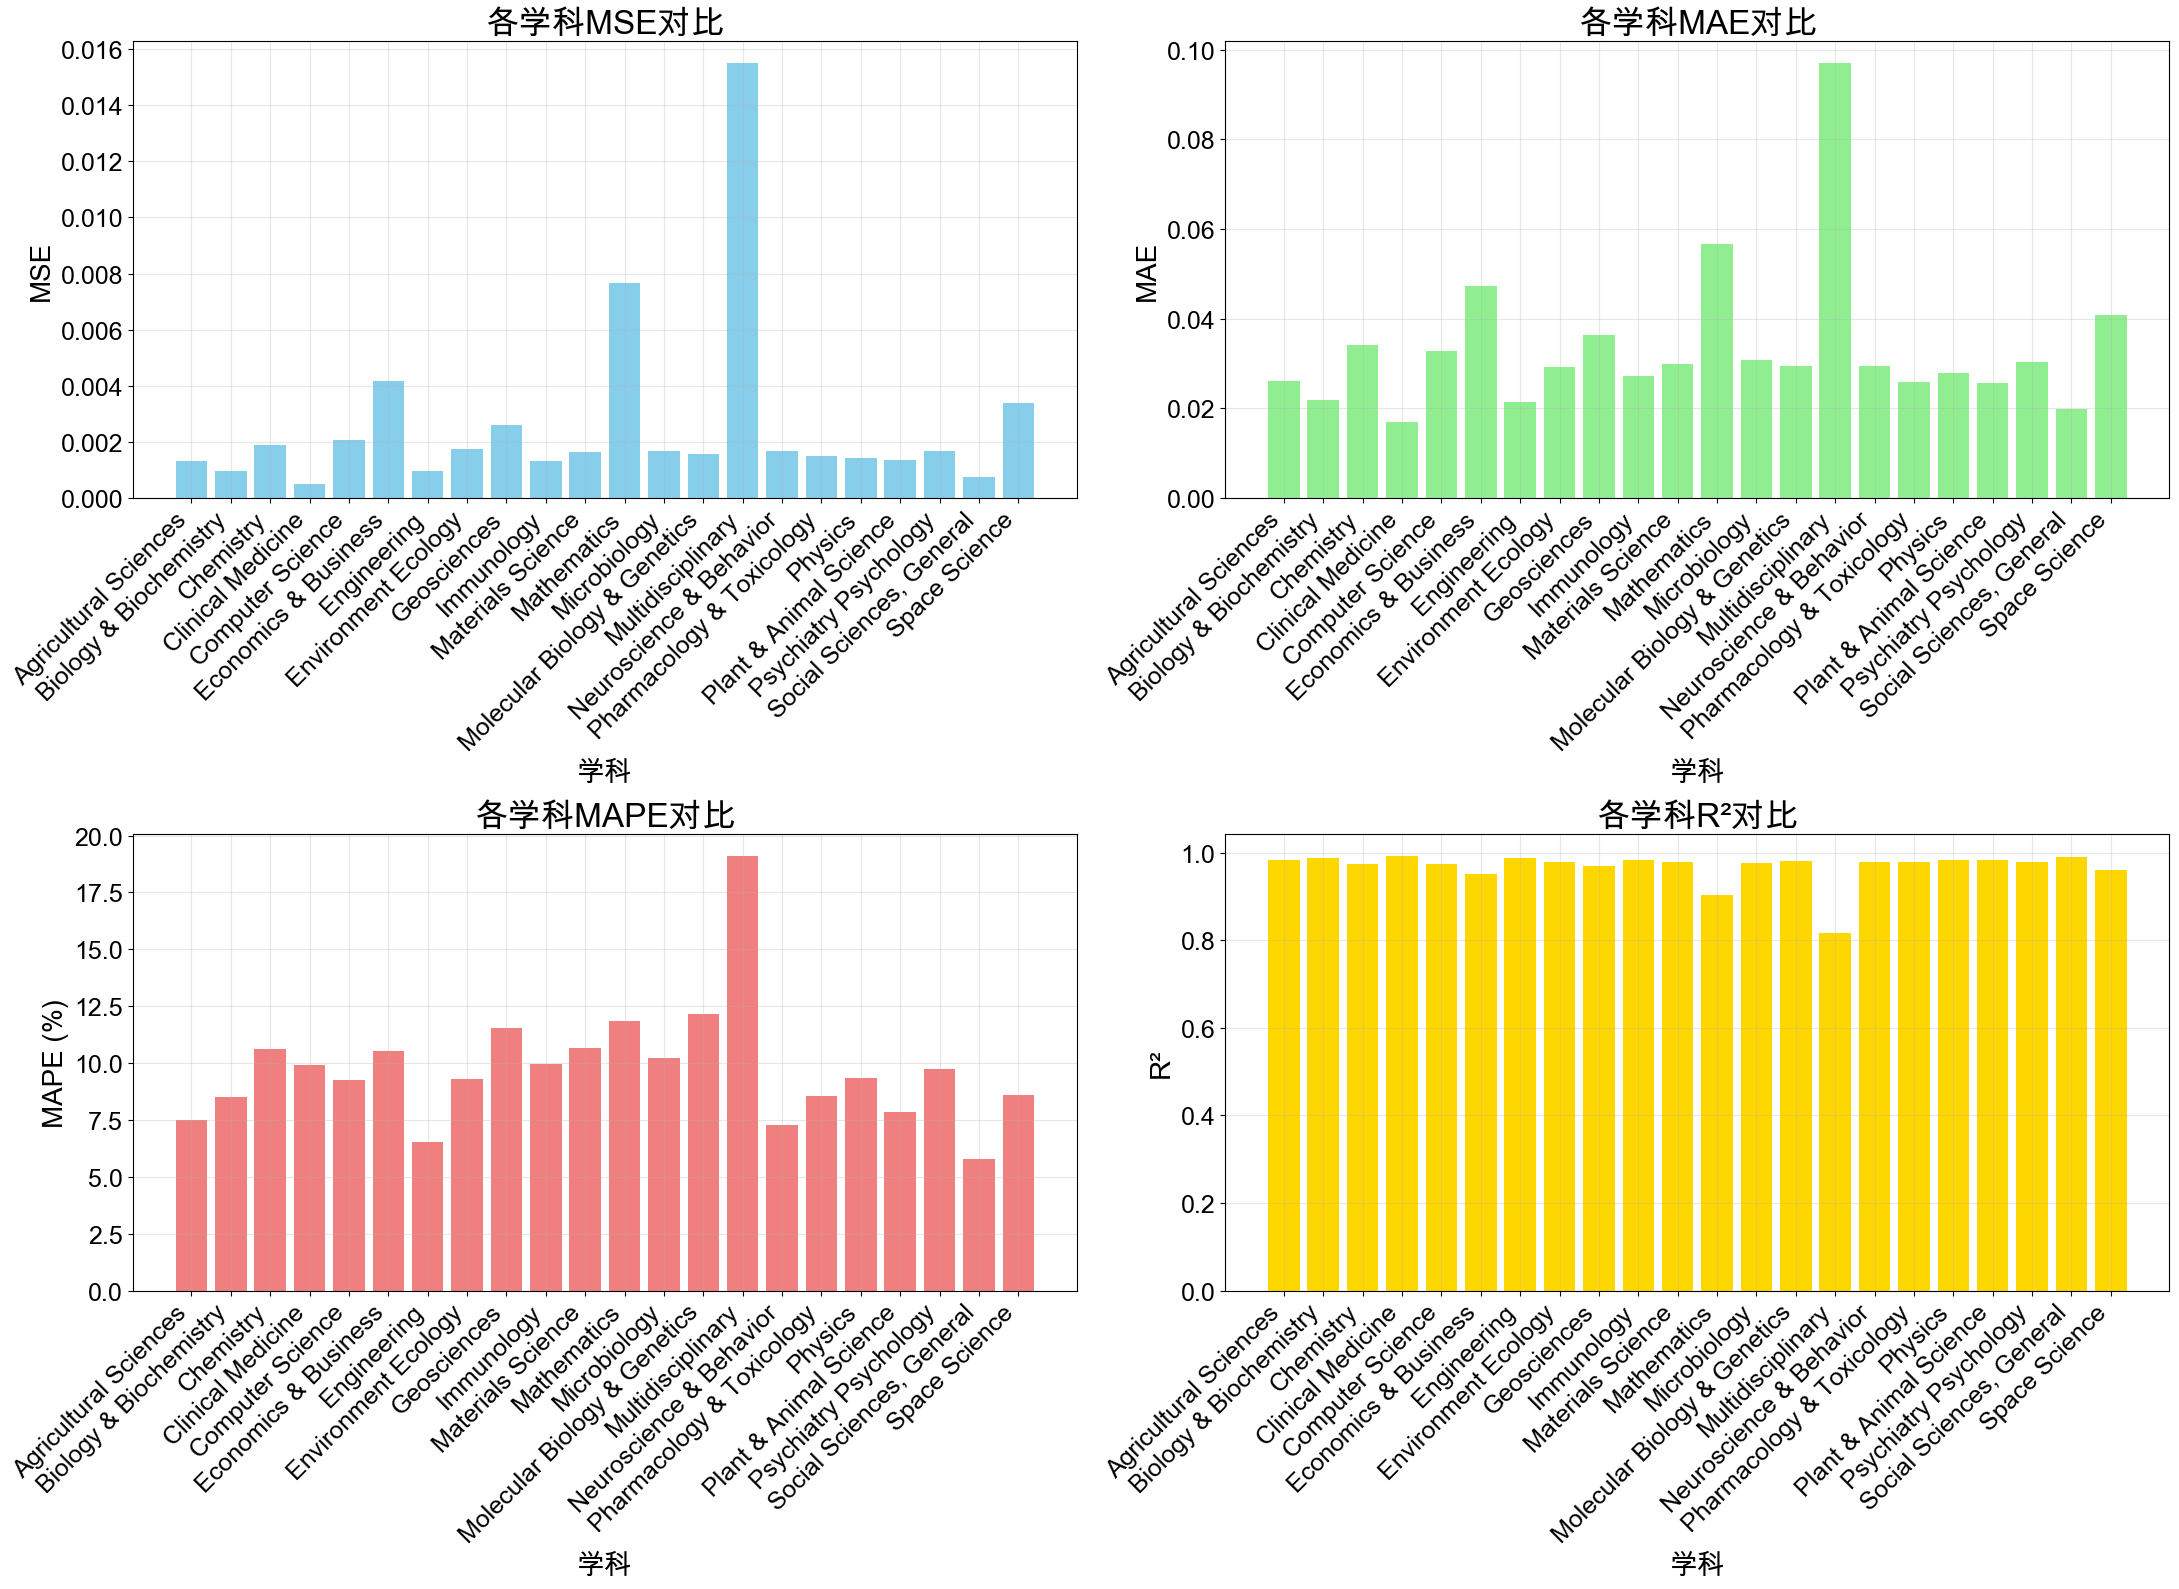

=== 模型表现分析 ===
最佳R²学科: Clinical Medicine (R² = 0.993996)
最差R²学科: Multidisciplinary (R² = 0.817153)
最佳MSE学科: Clinical Medicine (MSE = 0.000497)
最差MSE学科: Multidisciplinary (MSE = 0.015500)
最佳MAPE学科: Social Sciences, General (MAPE = 5.80%)
最差MAPE学科: Multidisciplinary (MAPE = 19.12%)


In [12]:
# 可视化每个学科的评价指标
fig, axes = plt.subplots(2, 2, figsize=(22, 16))

subject_names = list(all_subject_metrics.keys())
mse_values = [all_subject_metrics[name]['mse'] for name in subject_names]
mae_values = [all_subject_metrics[name]['mae'] for name in subject_names]
mape_values = [all_subject_metrics[name]['mape'] for name in subject_names]
r2_values = [all_subject_metrics[name]['r2'] for name in subject_names]

larger_font = 24
label_font = 20
tick_font = 18

# 1. MSE对比
axes[0, 0].bar(range(len(subject_names)), mse_values, color='skyblue')
axes[0, 0].set_title('各学科MSE对比', fontsize=larger_font, fontweight='bold')
axes[0, 0].set_xlabel('学科', fontsize=label_font)
axes[0, 0].set_ylabel('MSE', fontsize=label_font)
axes[0, 0].set_xticks(range(len(subject_names)))
axes[0, 0].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[0, 0].tick_params(axis='y', labelsize=tick_font)
axes[0, 0].grid(True, alpha=0.3)

# 2. MAE对比
axes[0, 1].bar(range(len(subject_names)), mae_values, color='lightgreen')
axes[0, 1].set_title('各学科MAE对比', fontsize=larger_font, fontweight='bold')
axes[0, 1].set_xlabel('学科', fontsize=label_font)
axes[0, 1].set_ylabel('MAE', fontsize=label_font)
axes[0, 1].set_xticks(range(len(subject_names)))
axes[0, 1].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[0, 1].tick_params(axis='y', labelsize=tick_font)
axes[0, 1].grid(True, alpha=0.3)

# 3. MAPE对比
axes[1, 0].bar(range(len(subject_names)), mape_values, color='lightcoral')
axes[1, 0].set_title('各学科MAPE对比', fontsize=larger_font, fontweight='bold')
axes[1, 0].set_xlabel('学科', fontsize=label_font)
axes[1, 0].set_ylabel('MAPE (%)', fontsize=label_font)
axes[1, 0].set_xticks(range(len(subject_names)))
axes[1, 0].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[1, 0].tick_params(axis='y', labelsize=tick_font)
axes[1, 0].grid(True, alpha=0.3)

# 4. R²对比
axes[1, 1].bar(range(len(subject_names)), r2_values, color='gold')
axes[1, 1].set_title('各学科R²对比', fontsize=larger_font, fontweight='bold')
axes[1, 1].set_xlabel('学科', fontsize=label_font)
axes[1, 1].set_ylabel('R²', fontsize=label_font)
axes[1, 1].set_xticks(range(len(subject_names)))
axes[1, 1].set_xticklabels(subject_names, rotation=45, ha='right', fontsize=tick_font)
axes[1, 1].tick_params(axis='y', labelsize=tick_font)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 显示最佳和最差表现的学科
from IPython.display import display, HTML

best_r2_subject = max(subject_names, key=lambda x: all_subject_metrics[x]['r2'])
worst_r2_subject = min(subject_names, key=lambda x: all_subject_metrics[x]['r2'])
best_mse_subject = min(subject_names, key=lambda x: all_subject_metrics[x]['mse'])
worst_mse_subject = max(subject_names, key=lambda x: all_subject_metrics[x]['mse'])
best_mape_subject = min(subject_names, key=lambda x: all_subject_metrics[x]['mape'])
worst_mape_subject = max(subject_names, key=lambda x: all_subject_metrics[x]['mape'])

print("=== 模型表现分析 ===")
print(f"最佳R²学科: {best_r2_subject} (R² = {all_subject_metrics[best_r2_subject]['r2']:.6f})")
print(f"最差R²学科: {worst_r2_subject} (R² = {all_subject_metrics[worst_r2_subject]['r2']:.6f})")
print(f"最佳MSE学科: {best_mse_subject} (MSE = {all_subject_metrics[best_mse_subject]['mse']:.6f})")
print(f"最差MSE学科: {worst_mse_subject} (MSE = {all_subject_metrics[worst_mse_subject]['mse']:.6f})")
print(f"最佳MAPE学科: {best_mape_subject} (MAPE = {all_subject_metrics[best_mape_subject]['mape']:.2f}%)")
print(f"最差MAPE学科: {worst_mape_subject} (MAPE = {all_subject_metrics[worst_mape_subject]['mape']:.2f}%)")


## 保存模型

In [13]:
# 保存模型
import os
model_dir = Path('model')
model_dir.mkdir(exist_ok=True)

print(f"\n=== 保存模型 ===")
for subject_name, model in subject_models.items():
    model_path = model_dir / f"{subject_name}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"已保存: {model_path}")

print(f"\n共保存了 {len(subject_models)} 个模型文件")



=== 保存模型 ===
已保存: model/Agricultural Sciences.pth
已保存: model/Biology & Biochemistry.pth
已保存: model/Chemistry.pth
已保存: model/Clinical Medicine.pth
已保存: model/Computer Science.pth
已保存: model/Economics & Business.pth
已保存: model/Engineering.pth
已保存: model/Environment Ecology.pth
已保存: model/Geosciences.pth
已保存: model/Immunology.pth
已保存: model/Materials Science.pth
已保存: model/Mathematics.pth
已保存: model/Microbiology.pth
已保存: model/Molecular Biology & Genetics.pth
已保存: model/Multidisciplinary.pth
已保存: model/Neuroscience & Behavior.pth
已保存: model/Pharmacology & Toxicology.pth
已保存: model/Physics.pth
已保存: model/Plant & Animal Science.pth
已保存: model/Psychiatry Psychology.pth
已保存: model/Social Sciences, General.pth
已保存: model/Space Science.pth

共保存了 22 个模型文件


# 预测

In [15]:
# 修改预测函数：使用真实的排名范围进行反归一化
def predict_school_rankings_fixed(school_idx, subject_names):
    """预测一所学校在所有学科的排名（使用真实排名范围）"""
    predictions = {}
    actual_rankings = {}
    
    for subject_name in subject_names:
        if subject_name in subject_data: # 检查该学科是否存在
            model = subject_models[subject_name]  # 加载该学科的模型（直接从已加载的变量中获取）
            test_data = subject_data[subject_name] # 获取该学科的数据
            # 检查是否有足够的数据
            if school_idx < len(test_data['X_test']):
                X_test = torch.FloatTensor(test_data['X_test'][school_idx]).reshape(1, -1)
                y_test = test_data['y_test'][school_idx]
                # 预测
                with torch.no_grad():
                    pred_normalized = model(X_test).item()
                # 使用真实的排名范围进行反归一化
                if subject_name in subject_ranking_ranges:
                    ranges = subject_ranking_ranges[subject_name]
                    min_rank = ranges['min_rank']
                    max_rank = ranges['max_rank']
                else:
                    min_rank, max_rank = 1, 1000
                pred_ranking = max_rank - pred_normalized * (max_rank - min_rank)
                actual_ranking = max_rank - y_test * (max_rank - min_rank)
                
                predictions[subject_name] = pred_ranking
                actual_rankings[subject_name] = actual_ranking
            else:
                # 如果没有足够的数据，设为0
                predictions[subject_name] = 0
                actual_rankings[subject_name] = 0
        else:
            # 如果学科不存在，设为0
            predictions[subject_name] = 0
            actual_rankings[subject_name] = 0
    
    return predictions, actual_rankings

selected_schools = {}

# 选择3所学校，每所学校预测所有22个学科
for school_idx in range(3):
    school_name = f"学校{school_idx+1}"
    
    predictions, actual_rankings = predict_school_rankings_fixed(school_idx, academic_fields)
    
    selected_schools[school_name] = {
        'predictions': predictions,
        'actual_rankings': actual_rankings
    }
    
print(f"预测了{len(selected_schools)}所学校")
    

预测了3所学校


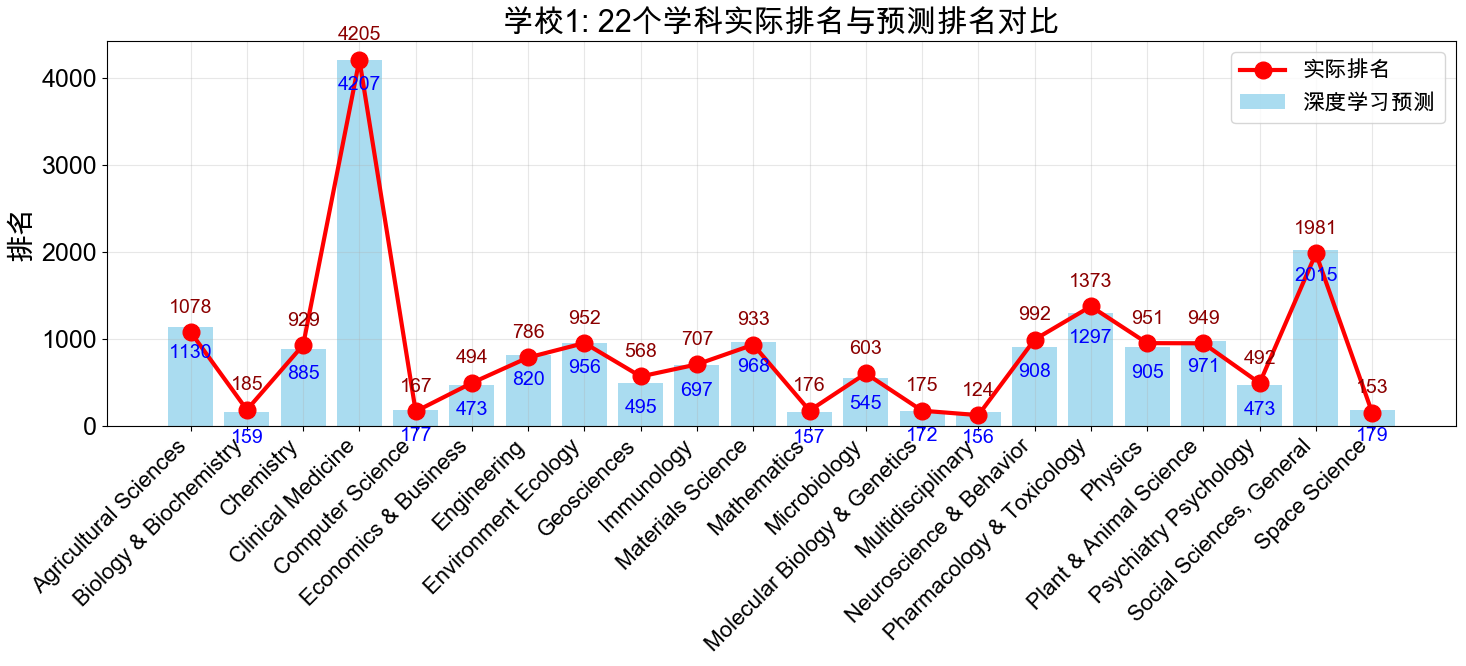

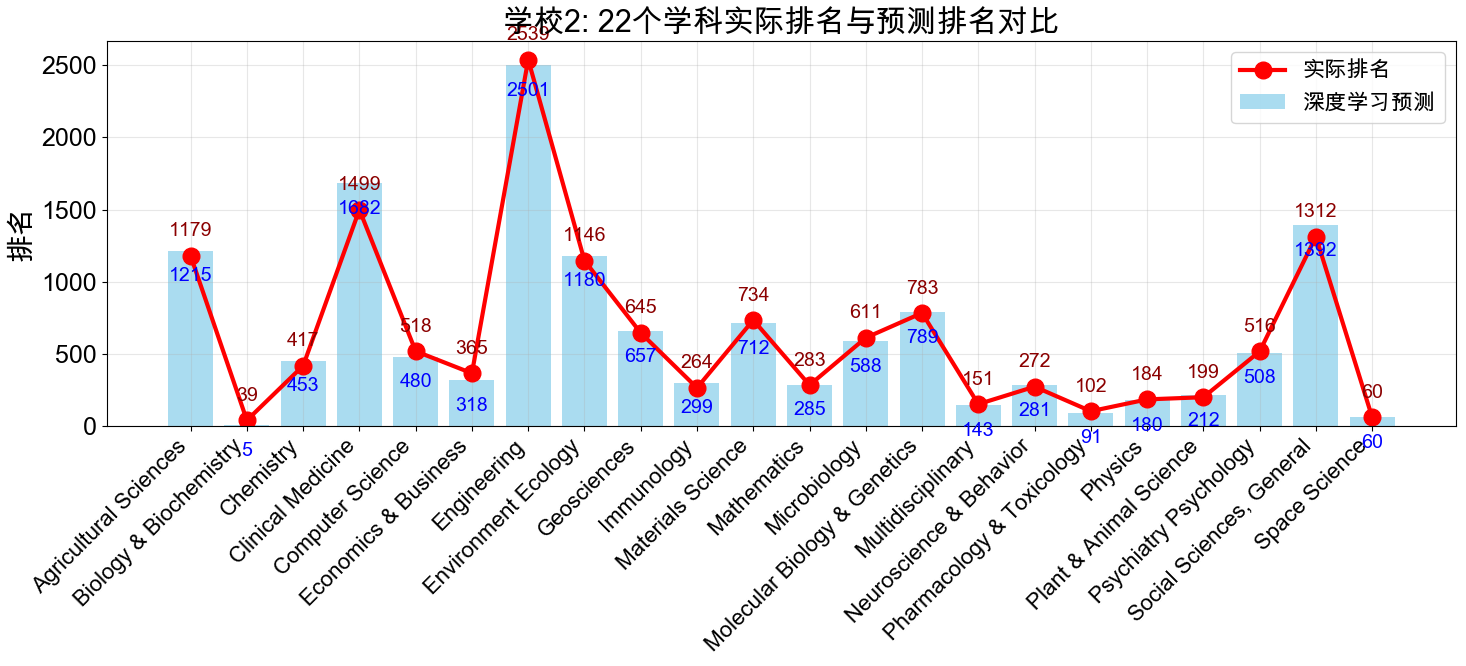

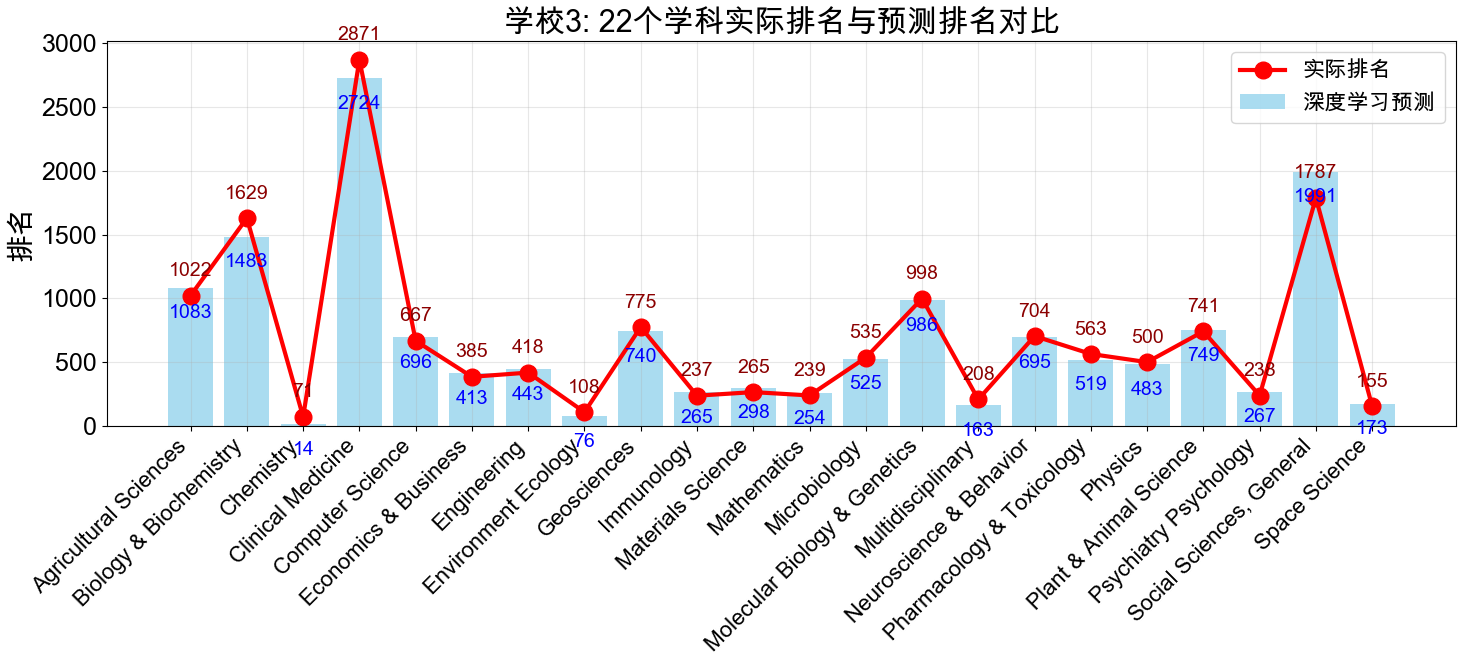

In [16]:
# 可视化预测结果
plt.rcParams.update({'font.size': 18})

for school_name, data in selected_schools.items():
    predictions = data['predictions']
    actual_rankings = data['actual_rankings']
    
    # 获取学科名称和对应的排名值
    subjects = list(predictions.keys())
    pred_values = [predictions[subject] for subject in subjects]
    actual_values = [actual_rankings[subject] for subject in subjects]
    
    fig, ax = plt.subplots(figsize=(15, 7))
    # 创建柱状图和折线图
    x_pos = range(len(subjects))
    # 绘制预测排名（柱状图）
    bars = ax.bar(x_pos, pred_values, alpha=0.7, color='skyblue', label='深度学习预测')
    # 绘制实际排名（折线图）
    line = ax.plot(x_pos, actual_values, 'o-', color='red', linewidth=3, 
                   markersize=12, label='实际排名')
    ax.set_title(f'{school_name}: 22个学科实际排名与预测排名对比', fontsize=22, fontweight='bold')
    ax.set_ylabel('排名', fontsize=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(subjects, rotation=45, ha='right', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=16)
    # 在数据点上添加数值标签
    for j, (actual, pred) in enumerate(zip(actual_values, pred_values)):
        if actual > 0:  # 只对实际排名非零的学科添加标签
            ax.annotate(f'{int(actual)}', (j, actual), 
                        textcoords="offset points", xytext=(0,14), ha='center', fontsize=14, color='darkred')
        if pred > 0:
            ax.annotate(f'{int(pred)}', (j, pred), 
                        textcoords="offset points", xytext=(0,-22), ha='center', fontsize=14, color='blue')
    plt.tight_layout()
    plt.show()


## 模型总结

本深度学习学科排名预测模型具有以下特点：

### 模型架构
- **输入特征**: 3个特征（Web of Science Documents, Cites, Top Papers）
- **网络结构**: 4层全连接神经网络，包含Dropout防止过拟合
- **输出**: Sigmoid激活函数，输出范围[0,1]，对应归一化后的排名

### 训练策略
- **分学科训练**: 每个学科单独训练模型，避免不同学科间的数据干扰
- **数据划分**: 每个学科按60%训练集、20%验证集、20%测试集划分
- **数据打乱**: 每个学科数据单独随机打乱，确保训练效果

### 评价指标
- **MSE**: 均方误差，衡量预测值与真实值的平方差
- **MAE**: 平均绝对误差，衡量预测值与真实值的绝对差
- **MAPE**: 平均绝对百分比误差，以百分比形式表示误差
- **R²**: 决定系数，衡量模型解释数据变异的程度
- **RMSE**: 均方根误差，MSE的平方根

### 模型优势
1. **学科特异性**: 每个学科独立训练，更好地捕捉学科特点
2. **结构简洁**: 代码量少但功能完整
3. **防过拟合**: 使用Dropout和验证集监控
4. **归一化处理**: 对排名进行反向归一化，便于模型学习
5. **全面评估**: 使用多种评价指标全面评估模型性能
6. **可视化分析**: 提供各学科对比、训练过程等多维度可视化

### 实验结果
- 为22个学科分别训练了独立的排名预测模型
- 每个模型都使用相同的网络架构但独立优化
- 通过对比分析可以识别哪些学科的排名更容易预测
